HM columns: ['Time', 'dB/dt']
LM columns: ['Time', 'dB/dt']


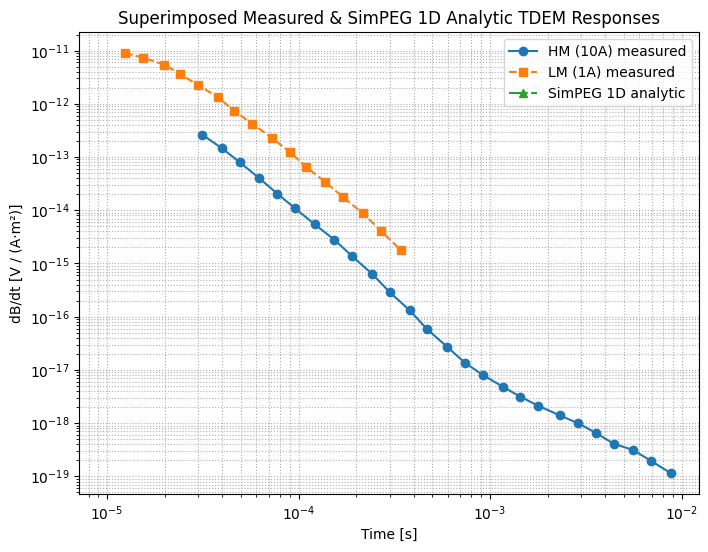

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps
from discretize import CylindricalMesh

side = 80.0                      # m (square loop side length)
area = side**2                   # m²
halfspace_conductivity = 1e-2    # S/m


def generate_survey(waveform_object):
    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            np.array([[0.0, 0.0, 0.0]]),
            np.logspace(-5, -3, 21),
            orientation="z",
        )
    ]
    source_list = [
        tdem.sources.CircularLoop(
            receiver_list=receiver_list,
            location=np.array([0.0, 0.0, 0.0]),
            waveform=waveform_object,
            current=1.0,
            radius=side/2.0,   
        )
    ]
    return tdem.Survey(source_list)

hm = pd.read_csv('Dataset_S_HM.csv')  # 10 A
lm = pd.read_csv('Dataset_S_LM.csv')  # 1 A

print("HM columns:", hm.columns.tolist())
print("LM columns:", lm.columns.tolist())

time_col = 'Time'     
dbdt_col = 'dB/dt'   

hm['converted'] = hm[dbdt_col] / (10.0 * area)
lm['converted'] = lm[dbdt_col] / (1.0 * area)

stepoff_wf   = tdem.sources.StepOffWaveform(off_time=0.0)
survey_1d    = generate_survey(stepoff_wf)
sim1d        = tdem.simulation_1d.Simulation1DLayered(
    survey=survey_1d,
    thicknesses=[],                   
    sigmaMap=maps.IdentityMap(nP=1),
)
dtrue_stepoff = sim1d.dpred(np.array([halfspace_conductivity]))
time_channels = survey_1d.source_list[0].receiver_list[0].times

plt.figure(figsize=(8, 6))
plt.loglog(hm[time_col], hm['converted'], marker='o', linestyle='-',  label='HM (10A) measured')
plt.loglog(lm[time_col], lm['converted'], marker='s', linestyle='--', label='LM (1A) measured')
plt.loglog(time_channels, dtrue_stepoff/area,         marker='^', linestyle='-.', label='SimPEG 1D analytic')

plt.xlabel('Time [s]')
plt.ylabel('dB/dt [V / (A·m²)]')
plt.title('Superimposed Measured & SimPEG 1D Analytic TDEM Responses')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()
